In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from PIL import Image

import matplotlib.pyplot as plt # for plotting
import numpy as np
import nltk
import time
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
os.chdir('/content/drive/My Drive/train/')

### Image Transforms

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is  
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        return img


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return image


IMAGE_RESIZE = (256, 256)
# Sequentially compose the transforms
img_transform = transforms.Compose([Rescale(IMAGE_RESIZE), ToTensor()])


### Captions Preprocessing

In [5]:
import string

def remove_punc(caption):
    for x in caption.lower():
        if x in string.punctuation: 
            caption = caption.replace(x, "")

    return ("<START> " + caption + " <END>")


In [6]:
remove_punc("SMFK. 'sfsdv zxvmskdzm Cdc")

'<START> SMFK sfsdv zxvmskdzm Cdc <END>'

In [7]:
import random

class CaptionsPreprocessing:
    """Preprocess the captions, generate vocabulary and convert words to tensor tokens

    Args:
        captions_file_path (string): captions tsv file path
    """
    def __init__(self, captions_file_path):
        self.captions_file_path = captions_file_path

        # Read raw captions
        self.raw_captions_dict = self.read_raw_captions()

        # Preprocess captions
        self.captions_dict = self.process_captions()

        # Create vocabulary
        self.vocab, self.vocab_index = self.generate_vocabulary()

    def read_raw_captions(self):
        """
        Returns:
            Dictionary with raw captions list keyed by image ids (integers)
        """

        captions_dict = {}
        with open(self.captions_file_path, 'r', encoding='utf-8') as f:
            for img_caption_line in f.readlines():
                img_captions = img_caption_line.strip().split('\t')
                captions_dict[int(img_captions[0])] = img_captions[1:]
        return captions_dict

    def process_captions(self):
        """
        Use this function to generate dictionary and other preprocessing on captions
        """

        raw_captions_dict = self.raw_captions_dict

        # Preprocessing
        captions_dict = raw_captions_dict

        for key in captions_dict:
            img_caption = captions_dict[key]
            captions_dict[key] = list(map(remove_punc, captions_dict[key]))

        return captions_dict

    def generate_vocabulary(self):
        """
        Use this function to generate dictionary and other preprocessing on captions
        """

        vocab_dict = {}
        vocab_index_dict = {}

        captions_dict = self.captions_dict

        vocab_dict["<XXX"] = 0
        vocab_dict["<START>"] = 1
        vocab_dict["<END>"] = 2

        vocab_index_dict[0] = "<XXX>"
        vocab_index_dict[1] = "<START>"
        vocab_index_dict[2] = "<END>"

        counter = 3

        # Generate the vocabulary
        for key in captions_dict:
            for i in range(5):
                caption = (captions_dict[key][i]).strip().split()
                for word in caption:
                    if word not in vocab_dict.keys():
                        vocab_dict[word] = counter
                        vocab_index_dict[counter] = word
                        counter+=1

        return vocab_dict, vocab_index_dict

    def captions_transform(self, img_caption_list):
        """
        Use this function to generate tensor tokens for the text captions
        Args:
            img_caption_list: List of captions for a particular image
        """
        vocab = self.vocab

        # Generate tensors
        # token_vec = torch.zeros(len(img_caption_list), 80)
        
        token_vec = []


        caption_list = img_caption_list[random.choice([0,1,2,3,4])].strip().split()
        # caption_list = img_caption_list[0].strip().split()

        for word in caption_list:
          token_vec.append(vocab[word])
          if(vocab[word]==2):
            break

        # for i,caption in enumerate(img_caption_list):
        #   caption_list = img_caption_list[i].strip().split()
        #   for j,word in enumerate(caption_list):
        #     token_vec[i,j] = (vocab[word])

        # return token_vec.long()
        return torch.LongTensor(token_vec)

# Set the captions tsv file path
CAPTIONS_FILE_PATH = './train_captions/train_captions.tsv'
captions_preprocessing_obj = CaptionsPreprocessing(CAPTIONS_FILE_PATH)


In [8]:
print("Length of vocabulary is %d"% len(captions_preprocessing_obj.vocab))
# captions_preprocessing_obj.captions_transform(captions_preprocessing_obj.captions_dict[0])

Length of vocabulary is 22179


### Dataset Class

In [9]:
class ImageCaptionsDataset(Dataset):

    def __init__(self, img_dir, captions_dict, img_transform=None, captions_transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            captions_dict: Dictionary with captions list keyed by image ids (integers)
            img_transform (callable, optional): Optional transform to be applied
                on the image sample.

            captions_transform: (callable, optional): Optional transform to be applied
                on the caption sample (list).
        """
        self.img_dir = img_dir
        self.captions_dict = captions_dict
        self.img_transform = img_transform
        self.captions_transform = captions_transform

        self.image_ids = list(captions_dict.keys())
  

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, 'image_{}.jpg'.format(self.image_ids[idx]))
        image = Image.open(img_name)
        captions = self.captions_dict[self.image_ids[idx]]

        if self.img_transform:
            image = self.img_transform(image)

        if self.captions_transform:
            captions = self.captions_transform(captions)

        sample = {'image': image, 'captions': captions}

        # return image.unsqueeze(0),captions
        return sample

In [10]:
class ImageTestDataset(Dataset):

    def __init__(self, img_dir, img_transform=None,):
        """
        Args:
            img_dir (string): Directory with all the images.
            img_transform (callable, optional): Optional transform to be applied
                on the image sample.
        """
        self.img_dir = img_dir
        self.img_transform = img_transform

        self.image_ids = list(captions_dict.keys())
  

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, 'image_{}.jpg'.format(self.image_ids[idx]))
        image = Image.open(img_name)

        if self.img_transform:
            image = self.img_transform(image)

        sample = {'image': image}

        return sample

In [11]:
def collate_fn(batch):
  res = {}

  res['image'] = [sample['image'].unsqueeze(0) for sample in batch] 
  res['image'] = torch.cat((res['image']), dim=0)

  res['captions'] = [sample['captions'] for sample in batch]
  res['captions'] = torch.nn.utils.rnn.pad_sequence(res['captions'], batch_first=True)

  return res

### Model Architecture

In [31]:
#  class EncoderCNN(nn.Module):
#     def __init__(self, embed_size):
#         super(EncoderCNN, self).__init__()
#         resnet = models.resnet50(pretrained=True)
#         for param in resnet.parameters():
#             param.requires_grad_(False)
        
#         modules = list(resnet.children())[:-1]
#         self.resnet = nn.Sequential(*modules)
#         self.embed = nn.Linear(resnet.fc.in_features, embed_size)

#     def forward(self, images):
#         features = self.resnet(images)
#         # print(features.shape)
#         features = features.view(features.size(0), -1)
#         features = self.embed(features)
#         return features

class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()
    
    self.num_classes = 512

    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(64, 192, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(192, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    ) 
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, self.num_classes),
    )

    self.sigmoid = nn.Sigmoid()

    # self.embed = nn.Linear(self.num_classes, embed_size)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, images):
    features = self.features(images)
    features = self.avgpool(features)
    features = torch.flatten(features, 1)
    features = self.classifier(features)
    # print(features)

    return features

In [32]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(input_size = embed_size,hidden_size = hidden_size,
                          num_layers = num_layers, dropout=0.8 if num_layers > 1 else 0,
                          batch_first = True)
        

        self.linear = nn.Linear(hidden_size, vocab_size)

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embed = self.embedding_layer(captions)

        embed = torch.cat((features.unsqueeze(1), embed), dim = 1)
        lstm_outputs, _ = self.lstm(embed)
        out = self.linear(lstm_outputs)
        # out = self.softmax(out)

        return out

    def output_caption(self, inputs, states=None, max_len=25):
        output_sentence = []
        for i in range(max_len):
            lstm_outputs, states = self.lstm(inputs, states)
            out = self.linear(lstm_outputs.squeeze(1))
            output_sentence.append(out.max(1)[1].item())
            inputs = self.embedding_layer(last_pick).unsqueeze(1)
            if(last_pick.item()==2):
              break
        
        return output_sentence

### Training Loop

In [ ]:
IMAGE_DIR = '/content/drive/My Drive/train/train_images/'

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Creating the Dataset
train_dataset = ImageCaptionsDataset(
    IMAGE_DIR, captions_preprocessing_obj.captions_dict, img_transform=transform_train,
    captions_transform=captions_preprocessing_obj.captions_transform
)

# Define your hyperparameters
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUMBER_OF_EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_WORKERS = 4 # Parallel threads for dataloading
loss_function = nn.CrossEntropyLoss().cuda()

VOCAB_SIZE = len(captions_preprocessing_obj.vocab)

encode_net = EncoderCNN(EMBED_SIZE)
decode_net = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE)

parameters = list(decode_net.parameters()) + list(encode_net.classifier.parameters())

optimizer = optim.Adam(params = parameters, lr=LEARNING_RATE)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encode_net.to(device)
decode_net.to(device)

# Creating the DataLoader for batching purposes
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)

for epoch in range(NUMBER_OF_EPOCHS):
    start = time.time()
    for batch_idx, sample in enumerate(train_loader):
        # Zero the gradients.
        decode_net.zero_grad()
        encode_net.zero_grad()

        # print(list(decode_net.gru.parameters()))

        image_batch, captions_batch = sample['image'], sample['captions']
        # print(image_batch.shape)

        # print(captions_batch[0])

        # If GPU training required
        image_batch, captions_batch = image_batch.cuda(), captions_batch.cuda() 

        features = encode_net(image_batch)
        # print(features)
        output_captions = decode_net(features, captions_batch) 
        
        # print((output_captions.shape))
        # print(output_captions.view(-1, VOCAB_SIZE).shape)  
        # print((captions_batch.view(-1)).shape)

        loss = loss_function(output_captions.view(-1, VOCAB_SIZE), captions_batch.view(-1))
        loss.backward()
        # print(decode_net.linear.weight.grad)
        optimizer.step()
        # print(decode_net.lstm.weight_ih_l0)

        print("Epoch %d Batch %d Loss %0.3f Time %0.2f sec"% (epoch+1, batch_idx+1, loss.item(), time.time()-start))
        
        # if (batch_idx%50==0):
        #     torch.save(encode_net.state_dict(), './encode-state_nc.pkl')
        #     torch.save(decode_net.state_dict(), './decode-state_nc.pkl')

    print("Iteration: " + str(epoch + 1))

    torch.save(encode_net.state_dict(), './encode-state{}-scratch.pkl'.format(str(epoch+1)))
    torch.save(decode_net.state_dict(), './decode-state{}-scratch.pkl'.format(str(epoch+1)))

    end = time.time()
    print("\nTime Elapsed %0.3f sec\n"% (end-start))

Epoch 1 Batch 1 Loss 10.042 Time 23.51 sec
Epoch 1 Batch 2 Loss 8.281 Time 23.62 sec
Epoch 1 Batch 3 Loss 8.077 Time 25.70 sec
Epoch 1 Batch 4 Loss 6.800 Time 25.79 sec
Epoch 1 Batch 5 Loss 5.277 Time 46.63 sec
Epoch 1 Batch 6 Loss 5.655 Time 46.72 sec
Epoch 1 Batch 7 Loss 2.600 Time 47.89 sec
Epoch 1 Batch 8 Loss 4.436 Time 48.36 sec
Epoch 1 Batch 9 Loss 1.804 Time 72.52 sec
Epoch 1 Batch 10 Loss 4.928 Time 72.59 sec
Epoch 1 Batch 11 Loss 3.338 Time 72.68 sec
Epoch 1 Batch 12 Loss 3.396 Time 75.60 sec
Epoch 1 Batch 13 Loss 3.804 Time 95.71 sec
Epoch 1 Batch 14 Loss 3.281 Time 95.80 sec
Epoch 1 Batch 15 Loss 2.470 Time 95.89 sec
Epoch 1 Batch 16 Loss 3.447 Time 96.81 sec
Epoch 1 Batch 17 Loss 2.538 Time 118.29 sec
Epoch 1 Batch 18 Loss 2.770 Time 118.37 sec
Epoch 1 Batch 19 Loss 3.113 Time 118.45 sec
Epoch 1 Batch 20 Loss 2.061 Time 119.68 sec
Epoch 1 Batch 21 Loss 2.739 Time 140.74 sec
Epoch 1 Batch 22 Loss 2.862 Time 140.82 sec
Epoch 1 Batch 23 Loss 2.500 Time 140.91 sec
Epoch 1 Batc

### PREDICTION

In [ ]:
def greedy_search(decoder_output):
  """
  Args:
      decoder_output is output of decoder net with dimensions (batch_size)*(caption_size)*(vocab_size)
  """
  caption_output = {}
  
  for i in range(BATCH_SIZE):
    caption_indices = torch.argmax(decoder_output[i], dim=1)
    caption_output[i] = [captions_preprocessing_obj.vocab_index[x] for x in caption_indices]

  return caption_output

In [14]:
def make_sentence(caption_list):
  caption_str = ''

  for i in range(1,24):
    caption_str = caption_str + captions_preprocessing_obj.vocab_index[caption_list[i]]
    if(caption_list[i+1]==2):
      caption_str = caption_str + '.'
      break
      
    caption_str = caption_str + ' '


  return caption_str

In [29]:
# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(EMBED_SIZE)
encoder.eval()
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load('/content/drive/My Drive/train/encode-state_nc.pkl'))
decoder.load_state_dict(torch.load('/content/drive/My Drive/train/decode-state_nc.pkl'))

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
decoder.to(device)

RuntimeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


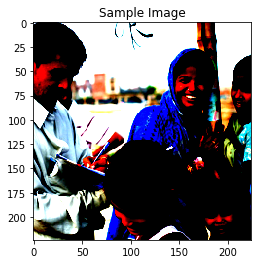

[1, 28, 29, 5, 55, 30, 31, 1438, 94, 55, 188, 5, 55, 30, 31, 13, 388, 102, 26, 556, 5, 55, 3740, 458, 2]


In [ ]:
for batch_idx, sample in enumerate(train_loader):

  img_batch, captions_batch = sample['image'], sample['captions']

  img_batch, captions_batch = img_batch.cuda(), captions_batch.cuda()

  img = img_batch[0]
  plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)), interpolation='nearest')
  plt.title('Sample Image')
  plt.show()

  # img1 = img_batch[1]
  # plt.imshow(np.transpose(img1.cpu().numpy(), (1,2,0)), interpolation='nearest')
  # plt.title('Sample Image')
  # plt.show()

  img_batch, captions_batch = img_batch.to(device), captions_batch.to(device)

  features = encoder(img[None,])
  # print(features)
  features=features.unsqueeze(1)
  output = decoder.output_caption(features)

  print(output)

  break

  # print(output)

  # features = encoder(img_batch)
  # output = decoder(features, captions_batch)

  # print(torch.argmax(output[0][3]))

In [ ]:
  caption_str = ''
  for i in range(1,18):
    caption_str = caption_str + captions_preprocessing_obj.vocab_index[output[i]] + " "
  

In [ ]:
  caption_str = []
  for i in range(1,80):
    if(captions_batch[0,i]==2):
      break
    caption_str.append(captions_preprocessing_obj.vocab_index[output[i]])
  

In [ ]:
print(caption_str)

['Un', 'uomo', 'con', 'una', 'maglietta', 'blu', 'leggera', 'e', 'una', 'donna', 'con', 'una', 'maglietta']


In [ ]:
  caption_obj = ''
  for i in range(1,15):
    caption_obj = caption_obj + (captions_preprocessing_obj.vocab_index[captions_batch[1,i].item()]) + ' '


In [ ]:
  caption_obj = []
  for i in range(1,80):
    if(captions_batch[0,i]==2):
      break
    caption_obj.append(captions_preprocessing_obj.vocab_index[captions_batch[1,i].item()])


In [ ]:
print(caption_obj)

['Gli', 'spettatori', 'guardano', 'un', 'gruppo', 'di', 'ballerini', 'le', 'braccia', 'interconnesse', 'e', 'i', 'colpi']


In [24]:
#Public Test
dict_img_captions = {}

IMAGE_DIR_PUBTEST = '/content/drive/My Drive/train/public_test_images/'

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

for file in os.listdir(IMAGE_DIR_PUBTEST):
  image = Image.open(IMAGE_DIR_PUBTEST+file)
  image = transform_train(image)

  image = image.to(device)

  features = encoder(image[None,])
  features=features.unsqueeze(1)
  output = decoder.output_caption(features)
  # print(output)

  dict_img_captions[(re.split('[_.]', file))[1]] = output

In [25]:
print(dict_img_captions['100'])

[1, 77, 188, 5, 55, 30, 31, 94, 55, 1135, 112, 94, 55, 1135, 458, 5, 26, 29, 14, 93, 320, 94, 112, 102, 1305]


In [26]:
with open('/content/drive/My Drive/train/2017CS10322_2017CS50417_public.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for key in dict_img_captions.keys():
      tsv_writer.writerow([key, make_sentence(dict_img_captions[key])])

In [21]:
import re

#Private Test
dict_img_priv_captions = {}

IMAGE_DIR_PRIVTEST = '/content/drive/My Drive/train/private_test_images/'

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

for file in os.listdir(IMAGE_DIR_PRIVTEST):
  print(file)
  image = Image.open(IMAGE_DIR_PRIVTEST+file)
  image = transform_train(image)

  image = image.to(device)

  features = encoder(image[None,])
  features=features.unsqueeze(1)
  output = decoder.output_caption(features)
  # print(output)

  dict_img_priv_captions[(re.split('[_.]', file))[1]] = output



image_9241.jpg
image_1358.jpg
image_8412.jpg
image_219.jpg
image_1576.jpg
image_6486.jpg
image_9592.jpg
image_6005.jpg
image_8561.jpg
image_5016.jpg
image_2851.jpg
image_10005.jpg
image_2523.jpg
image_199.jpg
image_2103.jpg
image_9274.jpg
image_2429.jpg
image_1284.jpg
image_4556.jpg
image_5581.jpg
image_7492.jpg
image_3539.jpg
image_9088.jpg
image_4007.jpg
image_2906.jpg
image_6334.jpg
image_2044.jpg
image_2956.jpg
image_7909.jpg
image_2803.jpg
image_5541.jpg
image_8554.jpg
image_6376.jpg
image_9506.jpg
image_6067.jpg
image_10124.jpg
image_9354.jpg
image_973.jpg
image_8872.jpg
image_8199.jpg
image_2180.jpg
image_8280.jpg
image_6078.jpg
image_8362.jpg
image_1030.jpg
image_828.jpg
image_9978.jpg
image_4881.jpg
image_6532.jpg
image_6781.jpg
image_9888.jpg
image_6258.jpg
image_9323.jpg
image_8611.jpg
image_1417.jpg
image_2909.jpg
image_10469.jpg
image_1771.jpg
image_4902.jpg
image_134.jpg
image_318.jpg
image_5595.jpg
image_2197.jpg
image_3701.jpg
image_6661.jpg
image_6031.jpg
image_9039.jp

In [ ]:
dict_img_priv_captions['5016']

[1, 28, 29, 5, 26, 39, 20, 3279, 94, 55, 331, 45, 107, 71, 204, 75, 55, 173, 2]

In [23]:
import csv

with open('/content/drive/My Drive/train/2017CS10322_2017CS50417_private.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for key in dict_img_priv_captions.keys():
      tsv_writer.writerow([key, make_sentence(dict_img_priv_captions[key])])